In [6]:
import numpy as np
import xarray as xr
import dask
from matplotlib import pyplot as plt
import matplotlib.colors
%matplotlib inline
from xmitgcm import open_mdsdataset
import pandas as pd
from floater import rclv
from scipy import interpolate
from skimage import measure

In [3]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 14,
      'legend.fontsize' : 12,'legend.handlelength': 2})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

In [4]:
## sla contours
data_dir = '/swot/SUM01/tongya/cox/fine/run_quik_ex2/'

ds = open_mdsdataset(data_dir,prefix='etan_ave').chunk()

sshlon = ds.XC
sshlat = ds.YC

ssh = ds['ETAN'][50:100, :, :]
ssh = ssh.mean('time')

dir_ssh = '/swot/SUM01/tongya/RCLV/flt_2d/001/'
ds = open_mdsdataset(dir_ssh, prefix='Eta').chunk()

mask = ds.hFacC[0, :, :]
tmp = ds['Eta'][0, :, :]
sla = tmp * mask - ssh

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [7]:
## rclv mask

lc = 0
rc = 144
sc = 10
nc = 35

rclv1 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/rclv_001.npy')
#rclv2 = np.load('./rclv_60_0.1/rclv_001.npy')
rclv3 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/rclv_001.npy')
id1 = np.where((rclv1[:,3]<0.1) & (rclv1[:,4]>-5))
id3 = np.where((rclv3[:,3]<0.1) & (rclv3[:,4]>-5))

rclv1_new = rclv1[id1[0], :]
rclv3_new = rclv3[id3[0], :]

mask1 = rclv.label_points_in_contours((2000, 11520), [c[1] for c in rclv1_new])

#mask2 = rclv_zwd.label_points_in_contours((2000, 11520), [c[1] for c in rclv2])
mask3 = rclv.label_points_in_contours((2000, 11520), [c[1] for c in rclv3_new])
mask1[np.where(mask1 > 0)] = 1
mask3[np.where(mask3 > 0)] = 1

dir1 = '/swot/SUM01/tongya/RCLV/output/flt_2d/001/float_trajectories_netcdf/'

ds1 = xr.open_mfdataset(dir1 + '*.nc')

xdata = ds1.sel(time=0, x0=slice(lc,rc), y0=slice(sc,nc)).x.load().data
ydata = ds1.sel(time=0, x0=slice(lc,rc), y0=slice(sc,nc)).y.load().data

rclvx1 = mask1 * xdata
rclvy1 = mask1 * ydata
rclvx3 = mask3 * xdata
rclvy3 = mask3 * ydata

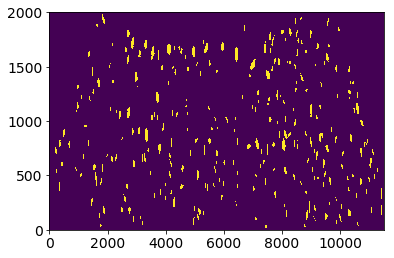

In [8]:
mask1[np.where(mask1 > 0)] = 1
plt.pcolormesh(mask1)

In [9]:
df = pd.read_pickle('/home/tls2913/scripts/SSH_eddy/eddy_df.pkl')
time = 10000001
dftmp = df.loc[(df['day']==time) & (df['x']>30) & (df['x']<90) & (df['y']<30)]


ssh_x = np.arange(0.05, 144, 0.1)
ssh_y = np.arange(10+0.05, 35, 0.1)
x_new = np.arange(0.00625, 144, 0.0125)
y_new = np.arange(10+0.00625, 35, 0.0125)
contours = []
for i in np.arange(dftmp.shape[0]):
#for i in np.arange(1):
    mask_eddy = np.zeros((250, 1440))
    eddyidx = dftmp.mask_lonid.iloc[i] - 1
    eddyidy = dftmp.mask_latid.iloc[i] - 1
    
    mask_eddy[eddyidy, eddyidx] = 1
    
    fun = interpolate.interp2d(ssh_x, ssh_y, mask_eddy)
    mask_tmp = fun(x_new, y_new)
    mask_tmp[np.where(mask_tmp > 0)] = 1
    mask_eddy_new = mask_tmp

    contours.append(measure.find_contours(mask_eddy_new, 0))    

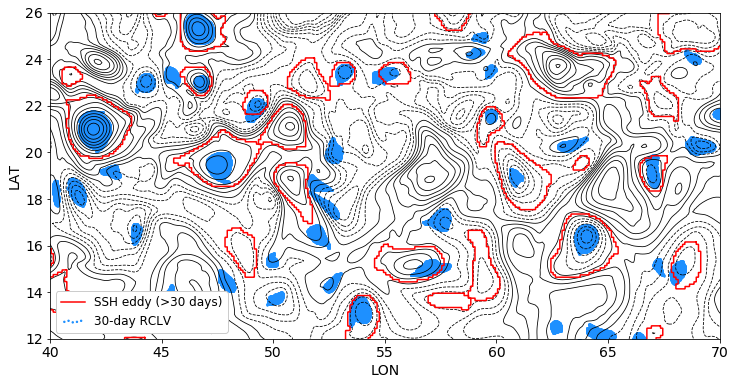

In [10]:
lev1 = np.arange(-50, 50, 2)
fig = plt.figure(figsize=(12, 6))

for i in np.arange(dftmp.shape[0]):
    bounx = x_new[contours[i][0].astype(int)[:,1]]
    bouny = y_new[contours[i][0].astype(int)[:,0]]

    hl1 = plt.plot(bounx, bouny, color='r')

hl2 = plt.scatter(rclvx1[:, 2200:6000], rclvy1[:, 2200:6000], s=2, color='dodgerblue')
#hl3 = plt.scatter(rclvx3[:, 2200:6000], rclvy3[:, 2200:6000], s=0.2, color='purple')

plt.contour(sshlon, sshlat, sla * 100, lev1, colors='k', linewidths=0.8)

legend = plt.legend([hl1[0], hl2], ('SSH eddy (>30 days)', '30-day RCLV'), loc=3, scatterpoints=5, framealpha=1)
legend.get_frame().set_facecolor('w')

plt.xlim(40, 70)
plt.ylim(12, 26)
plt.xlabel('LON')
plt.ylabel('LAT')

plt.savefig('Figure_03.png', dpi=300, bbox_inches='tight')